In [1]:
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import utils
import utils_cl

%matplotlib notebook
%load_ext autoreload

In [2]:
normal_df = pd.read_csv("dataset/normal_data_removed4months.csv")
fraud_df  = pd.read_csv("dataset/fraud_data_removed4months.csv")
normal_df.drop(columns = ['index'], inplace = True)
fraud_df.drop(columns = ['index'], inplace = True)
normal_df["IS_FRAUD"] = 0
fraud_df["IS_FRAUD"] = 1

df = pd.concat([normal_df, fraud_df], ignore_index=True, sort = False)
list_mdd = list(set(df['MA_DIEMDO']))
list_fraud_mdd = list(fraud_df['MA_DIEMDO'])
list_normal_mdd = list(normal_df['MA_DIEMDO'])

In [4]:
# Scale Data
X = df.iloc[:, 1:-1].values
Y = df.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_normalized = normalize(X_scaled, axis=1)
X_summary = pd.DataFrame(X_normalized)

In [5]:
reverse_dict = {}
for i in range(df.shape[0]):
    reverse_dict[tuple(X_summary.loc[i, :])] = df.iloc[i, 0]

In [6]:
# Clustering
## Distance using : Euclidean or DTW

distance_used = utils_cl.distance_ED
#distance_used = utils_cl.distance_DTW

n_iters = 500
cluster_number = 5
Clustering_result, centroids = utils_cl.K_Mean(np.array(X_summary), n_iters, cluster_number, metric = 'euclidean')

average_radius = []
for i, cent in enumerate(centroids) :
    s = 0
    for _p in Clustering_result[i+1]:
        EDist_cluster_p2c = distance_used(cent, _p)
        s += EDist_cluster_p2c
    s = s / (len(Clustering_result[i+1]))
    average_radius.append(s)

<IPython.core.display.Javascript object>


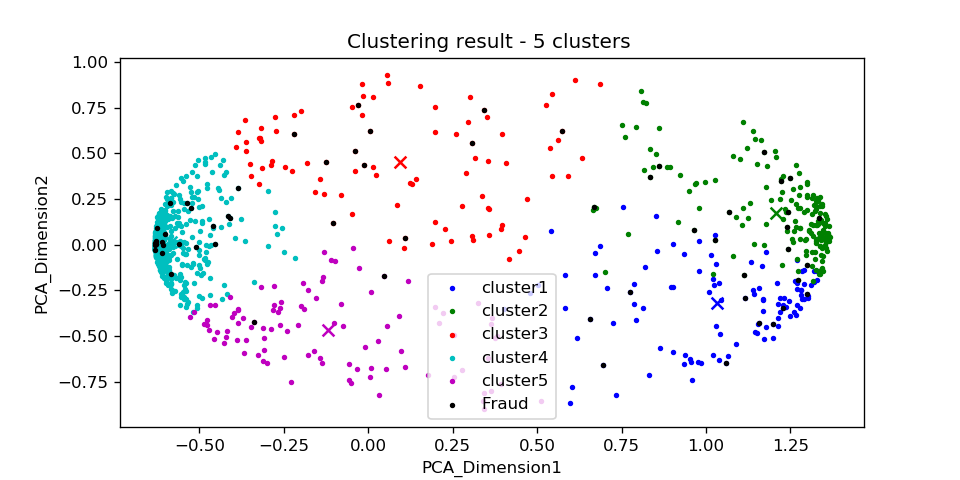

In [7]:
# Plot clustering result in PCA-2 Dimension
pca_plot = PCA(n_components=2)
principalComponents = pca_plot.fit(X_normalized)

result_2D = {}
i = 0
centroid_2D = []
list_fraud_2D = []
count_fraud = [0]*cluster_number
for _item in Clustering_result :
    result_2D[_item] = []
    for _point in Clustering_result[_item]:
        mdd_point = reverse_dict[tuple(_point)]
        point_2D = principalComponents.transform([_point])[0]
        result_2D[_item].append(point_2D)
        if mdd_point in list_fraud_mdd:
            list_fraud_2D.append(point_2D)
            count_fraud[_item - 1] += 1
    centroid_2D.append(principalComponents.transform([centroids[i]])[0])
    i += 1

def centroid_plt2D(result, cluster_number, centroid):
    plt.figure(figsize = (8, 4), dpi = 120)
    fraud_color = 'black'
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    labels=['cluster' + str(i+1) for i in range(cluster_number)]
    for k in range(cluster_number):
        d1 = [result[k+1][i][0] for i in range(len(result[k+1]))]
        d2 = [result[k+1][i][1] for i in range(len(result[k+1]))]
        plt.scatter(d1, d2, c=colors[k], s=5, label=labels[k])
        plt.scatter(centroid[k][0], centroid[k][1], s=50, c=colors[k], marker = "x")
    
    d1_fraud = [fr_point[0] for fr_point in list_fraud_2D]
    d2_fraud = [fr_point[1] for fr_point in list_fraud_2D]    
    plt.scatter(d1_fraud, d2_fraud, c=fraud_color, s=5, label = 'Fraud')
    
    plt.xlabel('PCA_Dimension1')
    plt.ylabel('PCA_Dimension2')
    plt.title("Clustering result - " + str(cluster_number) + " clusters ")
    plt.legend()
    plt.show()
centroid_plt2D(result_2D, cluster_number, centroid_2D)

In [ ]:
# Caculating CF (coincidence metric) for each Cluster
## CF calculate intra-cluster consistency
# Caculating LF ()
## LF analysising the shape of load curves (variation testing)

In [10]:
def Calculate_CF(cluster):
    S_ni = np.zeros(15)
    denominator = 0
    for p in cluster :
        p = np.array([ (i - min(p)) / (max(p) - min(p)) for i in p])
        S_ni = S_ni + p
        denominator += max(p)
    numerator = max(S_ni)
    CF = numerator/denominator
    return CF

def Calculate_LF(cluster):
    N_k = len(cluster)
    LF = 0
    for p in cluster :
        p = np.array([ (i - min(p) / (max(p) - min(p))) for i in p])
        numerator1 = sum(p)
        denominator1 = len(p)*max(p)
        ts1 = numerator1/denominator1
        LF += ts1
    LF = LF/N_k
    return LF

In [11]:
print("Cluster 1 : \n CF : {0} - LF : {1}".format(Calculate_CF(Clustering_result[1]), Calculate_LF(Clustering_result[1])))
print("Cluster 2 : \n CF : {0} - LF : {1}".format(Calculate_CF(Clustering_result[2]), Calculate_LF(Clustering_result[2])))
print("Cluster 3 : \n CF : {0} - LF : {1}".format(Calculate_CF(Clustering_result[3]), Calculate_LF(Clustering_result[3])))

Cluster 1 : 
 CF : 0.752805420839341 - LF : 0.4035027652297524
Cluster 2 : 
 CF : 0.6351207444696488 - LF : 0.4585947595524064
Cluster 3 : 
 CF : 0.6690042485010378 - LF : 0.5156901891037193


In [12]:
print("Count fraud each Cluster : ", count_fraud)
print("Count sample each Cluster : ", [len(i) for i in Clustering_result.values()])

Count fraud each Cluster :  [9, 16, 11, 22, 2]
Count sample each Cluster :  [111, 179, 92, 562, 99]


## Fraud conspicous experiment

In [95]:
conspicous_fraud = [] 
for p in Clustering_result[3]:
    if reverse_dict[tuple(p)] in list_fraud_mdd:
        print(reverse_dict[tuple(p)])
        conspicous_fraud.append(reverse_dict[tuple(p)])

PP01000103454001
PP05000948327001
PP05000951373001
PP05000516894001
PP01000131431001


In [13]:
conspicous_fraud_2 = [] 
for p in Clustering_result[5]:
    if reverse_dict[tuple(p)] in list_fraud_mdd:
        print(reverse_dict[tuple(p)])
        conspicous_fraud_2.append(reverse_dict[tuple(p)])

PP01000103454001
PP01000131431001


<IPython.core.display.Javascript object>


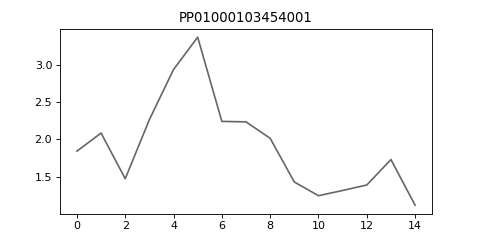

<IPython.core.display.Javascript object>


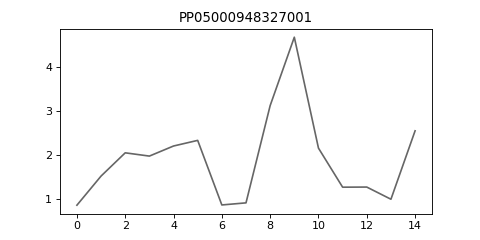

<IPython.core.display.Javascript object>


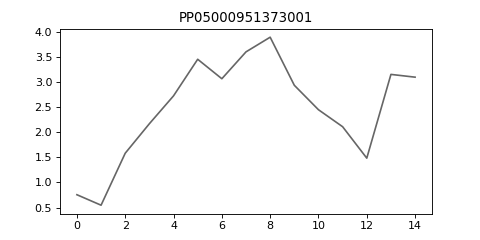

<IPython.core.display.Javascript object>


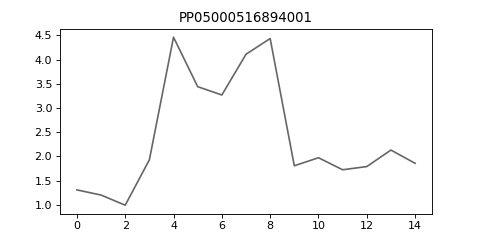

<IPython.core.display.Javascript object>


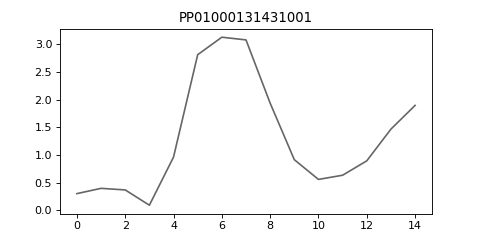

In [120]:
for i in range(len(conspicous_fraud)):
    plt.figure(figsize = (6, 3), dpi = 80)`
    pd.Series(df[df['MA_DIEMDO'] == conspicous_fraud[i]].values[0][1:-1]).plot(color='black',alpha=0.6)
    plt.title(conspicous_fraud[i])
    plt.show()

In [136]:
unconspicous_fraud_cluster1 = []
for p in Clustering_result[1]:
    if reverse_dict[tuple(p)] in list_fraud_mdd:
        unconspicous_fraud_cluster1.append(reverse_dict[tuple(p)])
unconspicous_fraud_cluster2 = []
for p in Clustering_result[2]:
    if reverse_dict[tuple(p)] in list_fraud_mdd:
        unconspicous_fraud_cluster2.append(reverse_dict[tuple(p)])

<IPython.core.display.Javascript object>


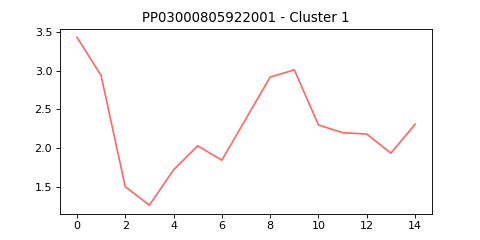

<IPython.core.display.Javascript object>


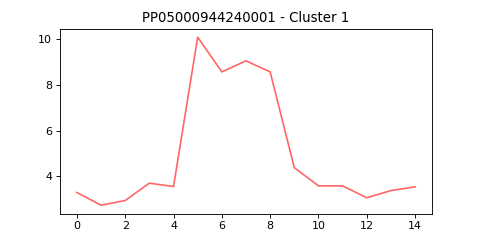

<IPython.core.display.Javascript object>


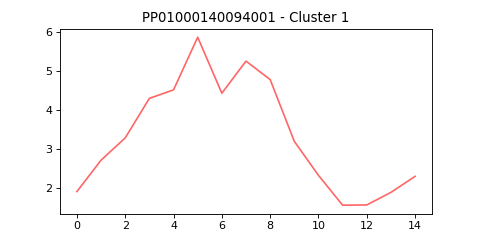

<IPython.core.display.Javascript object>


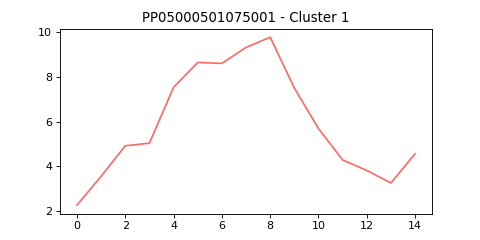

<IPython.core.display.Javascript object>


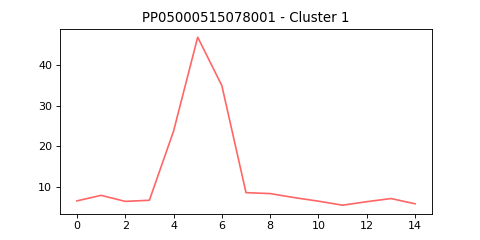

<IPython.core.display.Javascript object>


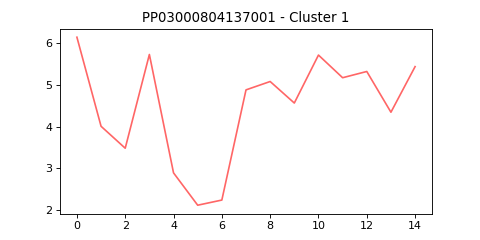

<IPython.core.display.Javascript object>


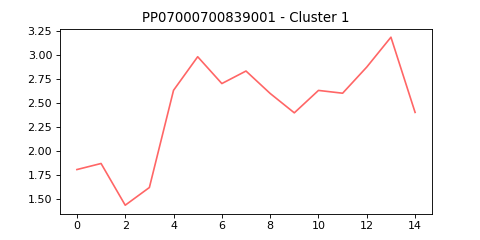

In [137]:
for i in range(len(unconspicous_fraud_cluster1)):
    plt.figure(figsize = (6, 3), dpi = 80)
    pd.Series(df[df['MA_DIEMDO'] == unconspicous_fraud_cluster1[i]].values[0][1:-1]).plot(color='red',alpha=0.6)
    plt.title(unconspicous_fraud_cluster1[i] + " - Cluster 1")
    plt.show()
    if i > 5:
        break

<IPython.core.display.Javascript object>


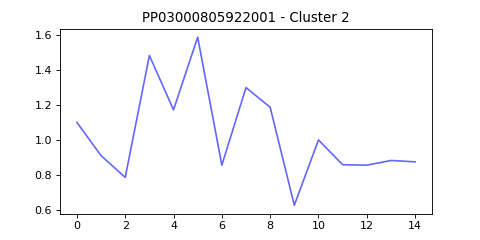

<IPython.core.display.Javascript object>


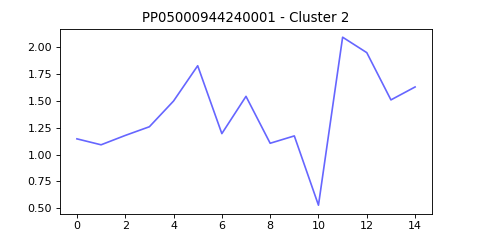

<IPython.core.display.Javascript object>


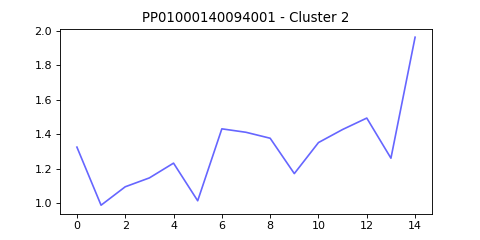

<IPython.core.display.Javascript object>


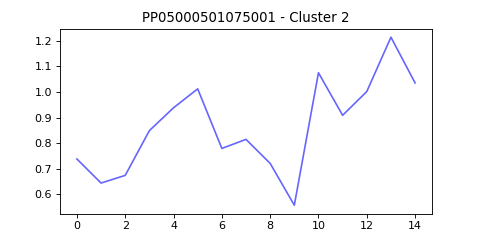

<IPython.core.display.Javascript object>


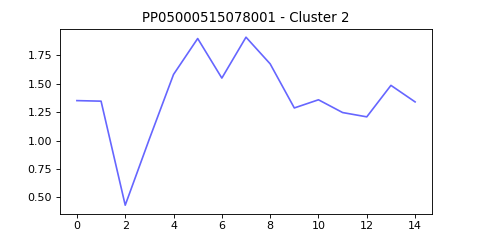

<IPython.core.display.Javascript object>


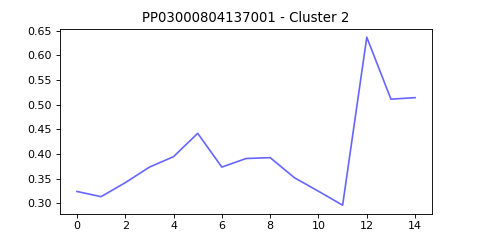

<IPython.core.display.Javascript object>


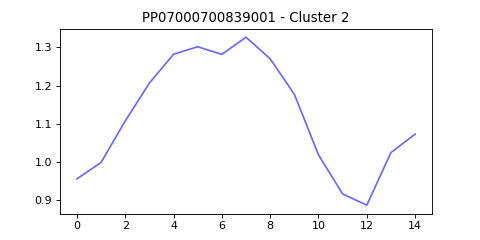

In [138]:
for i in range(len(unconspicous_fraud_cluster2)):
    plt.figure(figsize = (6, 3), dpi = 80)
    pd.Series(df[df['MA_DIEMDO'] == unconspicous_fraud_cluster2[i]].values[0][1:-1]).plot(color='blue',alpha=0.6)
    plt.title(unconspicous_fraud_cluster1[i] + " - Cluster 2")
    plt.show()
    if i > 5:
        break